In [51]:
import re
import os
import sys
import numpy as np
from keras.preprocessing.image import img_to_array
import matplotlib.image as mpimg

SIDE = 608
PATCH_SIZE = 16
TRESHOLD = 0.4

def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#used only on 608x608 images
def data_load(directory_name, RGB_image=False): 
    filenames = sorted_aphanumeric(os.listdir(directory_name))
    imgs = []
    i=0
    for fileNb in filenames:
        if(fileNb!='.DS_Store'):  
            full_name = directory_name+fileNb
            img=mpimg.imread(full_name)
            if RGB_image:
                imgr = img_to_array(img)
            else:
                imgr = img_to_array(img).reshape(SIDE, SIDE)
            imgs.append(imgr)
            i+=1
            sys.stdout.write("\rImage {}/{} is being loaded".format(i,len(filenames)))
            sys.stdout.flush()
    print()
    return np.asarray(imgs)

### Run this cell for all directories to copy and scale predictions to 608 pixels images

In [11]:
from PIL import Image
import os
path_from = "data/MEAN/pred_unet_512_98a/"
path_to = path_from

filenames = os.listdir(path_from)
for i, fileNb in enumerate(filenames):
    if(fileNb!='.DS_Store'):        
        im1 = Image.open(path_from+fileNb)
        side = SIDE
        im2 = im1.resize((side, side), Image.NEAREST)
        im2.save(path_to+fileNb)

In [34]:
original_data = data_load("data/tmp/", RGB_image=True)
IMGS = []
IMGS.append(data_load("data/MEAN/pred_unet_256_97_learning_1e-2a/"))
IMGS.append(data_load("data/MEAN/pred_unet_256_99_valida/"))

Image 50/51 is being loaded
Image 50/50 is being loaded
Image 50/50 is being loaded


In [35]:
def average_image(IMGS_folders):
    means = IMGS[0]
    print('Size should be (50, 608, 608):', means.shape) 
    for i in range(1,len(IMGS_folders)):
        for j, img in enumerate(IMGS_folders[i]):
            means[j]+=img
    return means/len(IMGS_folders)

In [36]:
means = average_image(IMGS)
print('Size should be (608, 608):',means[0].shape)

Size should be (50, 608, 608): (50, 608, 608)
Size should be (608, 608): (608, 608)


### First 4 images for each of our predictions set and the mean at the bottom


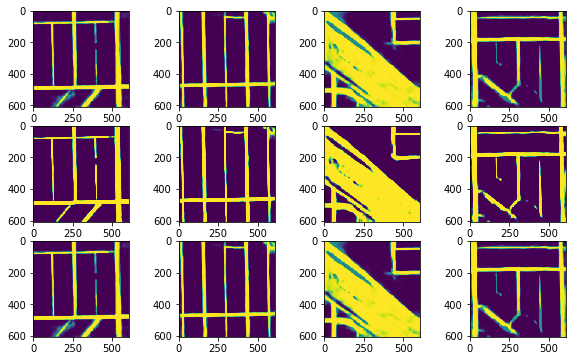

In [53]:
from matplotlib import pyplot as plt
f = 6
columns = 4
rows = int(len(IMGS))+1

fig=plt.figure(figsize=(10, 2*rows))
img_to_plot = IMGS[0][f:f+4]
for i in range(1, int(len(IMGS))):
    img_to_plot = np.append(img_to_plot,IMGS[i][f:f+4], axis=0)
img_to_plot = np.append(img_to_plot, means[f:f+4], axis=0)
for i in range(1, columns*rows +1):
    img = img_to_plot[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [43]:
def color_patch(patch, thresh=TRESHOLD):
    m = np.mean(patch)
    if(m>thresh):
        return 1, np.ones(16*16).reshape(16,16)
    else:
        return 0, np.zeros(16*16).reshape(16,16)

def color_patch_full(img):
    vs=[]
    patchs=[]
    img_patches = img_crop(img, PATCH_SIZE, PATCH_SIZE)
    for i in range(len(img_patches)):
        v, X = color_patch(img_patches[i])
        vs.append(v)
        patchs.append(X)
    patchs = np.asarray(patchs)
    return vs, patchs

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches


In [44]:
def patched_imgs_and_vs(means):
    vs_for_each_imgs = []
    imgs_means_patched = []
    for index, mean_img in enumerate(means):
        vs, patchs = color_patch_full(mean_img)
        vs_for_each_imgs.append(vs)
        
        #print(patchs.shape) = (1444, 16, 16)
        nb_patch_per_side = int(SIDE/PATCH_SIZE)
        patchs = patchs.reshape(nb_patch_per_side, nb_patch_per_side, PATCH_SIZE, PATCH_SIZE)
        #print(patchs.shape) = (38, 38, 16, 16)
        
        for j in range(0,nb_patch_per_side):
            
            tmp = patchs[j,0]
            for i in range(1,nb_patch_per_side):
                tmp = np.concatenate((tmp, patchs[j,i]), axis=1) 
            if(j==0):
                TMP = tmp
            else:
                TMP = np.concatenate((TMP, tmp), axis=0)
        imgs_means_patched.append(np.rot90(np.rot90(np.rot90(np.flip(TMP, 0)))))
        sys.stdout.write("\rImage {}/{} is being processed".format(index+1,len(means)))
        sys.stdout.flush()
    return imgs_means_patched, vs_for_each_imgs

In [45]:
patched_imgs, vs = patched_imgs_and_vs(means)

Image 50/50 is being processed

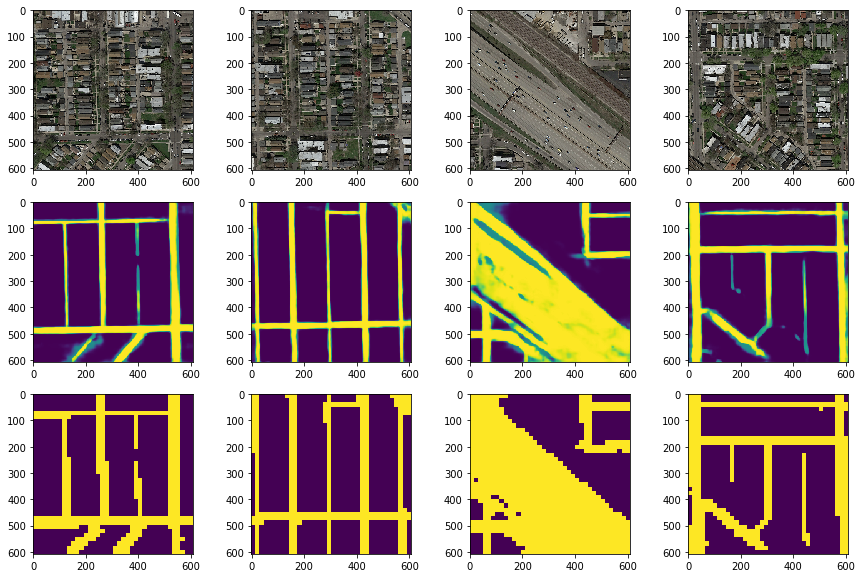

In [52]:
fig=plt.figure(figsize=(15, 10))
f = 6
columns = 4
rows = 3
img_to_plot0 = means[f:f+4]
img_to_plot1 =np.append(img_to_plot0, patched_imgs[f:f+4], axis=0)
for i in range(1, columns*rows +1):
    if(i<=4):
        img = original_data[f+i-1]
    else:
        img = img_to_plot1[i-5]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [47]:
import csv
def create_csv_submission(imgs, vs_for_each_imgs, name):
    labels = np.arange(0, SIDE, PATCH_SIZE)
    nb_patch_per_side = int(SIDE/PATCH_SIZE)
    with open(name, 'w') as csvfile:
        fieldnames = ['id', 'prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for nb, img in enumerate(imgs):
            ID = str(nb+1).zfill(3)
            row = 0
            col = 0
            for v in vs_for_each_imgs[nb]:
                col_ = col%nb_patch_per_side
                ID2 = ID+'_'+str(labels[row])+'_'+str(labels[col_])    
                writer.writerow({'id':ID2,'prediction':v})
                if(col == 37):
                    col=0
                    row+=1
                else:
                    col+=1

In [48]:
create_csv_submission(patched_imgs, vs, 'submissions/test_sub.csv')